## Importing the dataset and the neural network classes

In [1]:
from ipynb.fs.full.Dataset import *
from ipynb.fs.full.Network import *

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import optuna
import os
import time

## Describing the type of analysis and forming the testing DataLoaders

In [12]:
#defining total number of samples in the dataset
n = 100000

#analysis mode:
#Original | top-hat-k | density

analysis_mode = 'original'  #or 'density' or 'top-hat-k'

if analysis_mode == 'original':
    #no augmentations on the maps
    dens_case = 'original'
    dens_cut_str = None
    kmax_cut_str = None

elif analysis_mode == 'density':
    #no change in the fourier domain, but augmentations possible in then pixel density values
    dens_case = 'max'  #or 'min'
    dens_cut_str = '0.5'
    kmax_cut_str = None
    
elif analysis_mode == 'top-hat-k':
    #no change in the pixel density values, but top-hat-k filters are applied on the maps
    dens_case = 'original'
    kmax_cut_str = '0.1'

#original means no cuts on the GDF maps from which P(k) is formed
#max and min mean maximum and minimum density cuts on the maps respectively
case = 'original'

#value of the maximum or minimum density cut. Inconsequential for case = 'original'
dens_case = 'original'
dens_cut_str = None


#If A_true != None, that means that we are forming the whole dataset with a single value of the
#cosmological parameter A = A_true. If it is set as None, the value of A is sampled uniformly in
#the range [0.8,1.2]
A_true = None


#forming the dataset from the data generating class
data_set_test = data_gen(n, 'test', dens_case, dens_cut_str, kmax_cut_str, A_true)
test_dl = DataLoader(dataset=data_set_test, batch_size=128, shuffle=True)
print('Size of test dataset =', data_set_test.__len__())

Size of test dataset = 15000


## Checking for GPU availability

In [13]:
# use GPUs if available
import torch.backends.cudnn as cudnn

if torch.cuda.is_available():
    print("Using CUDA")
    #index = 0
    #torch.cuda.set_device(index)
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device1 = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory


if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        print("%d GPUs Available"%(torch.cuda.device_count()))
    print('GPU model:',torch.cuda.get_device_name())

else:
    print('Using CPU (Cuda unavailable)\n')
    

#print('Currently using device #:',torch.cuda.current_device())

Using CUDA
3 GPUs Available
GPU model: Tesla V100-SXM2-32GB


## Folder where weights are stores

In [14]:
if analysis_mode == 'original':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}'.format(analysis_mode)
elif analysis_mode == 'density':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}/{}'.format(analysis_mode, dens_case, dens_cut_str)
elif analysis_mode == 'top-hat-k':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}/{}'.format(analysis_mode, kmax_cut_str)
    
print('Folder: ' + dir_wt)

Folder: /mnt/ceph/users/alahiry/gaussian_fields/original


## Dictoinary containing the final trial parameters

#### (I am re-training it now as I accidentally overwrote the previous optuna database :/)

In [15]:
#forgot to save the optuna database
#thankfully copied the best parameters
#have to re-do ;_;

params_final = {
            'lr': 3.2458049378231884e-05,
            'wd': 3.5921264847791537e-06,
            'channel_1': 20,
            'channel_2': 18,
            'channel_3': 39,
            'channel_4': 179,
            'channel_5': 269
           }

## Loading the best model weights

In [16]:
model = Model_CNN_GDF(params_final)
if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)    


fweights_best =  dir_wt + '/weights_best.pt'


#if the path to the best weights file exists, loading them into the model:
if os.path.exists(fweights_best):  
    model.load_state_dict(torch.load(fweights_best, map_location=torch.device(device)))
print('\nModel and weights loaded!\n')

#displaying the total number of model parameters
total_params = sum(t.numel() for t in model.parameters())
print('\ntotal number of parameters in the model = %d'%total_params)


Model and weights loaded!


total number of parameters in the model = 902036


## Evaluating on the test set

In [28]:
A_true = np.zeros(data_set_test.__len__())
A_nn = np.zeros(data_set_test.__len__())
points = 0

for images, labels in test_dl:
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)
        A_true[points:points+images.shape[0]] = labels.cpu().numpy().flatten()
        A_nn[points:points+images.shape[0]] = out.cpu().numpy().flatten()
        points += images.shape[0]

A_nn = A_nn*(1.2-0.8) + 0.8
A_true = A_true*(1.2-0.8) + 0.8


## Neural network prediction vs tru values plot

0.0006493941941985791


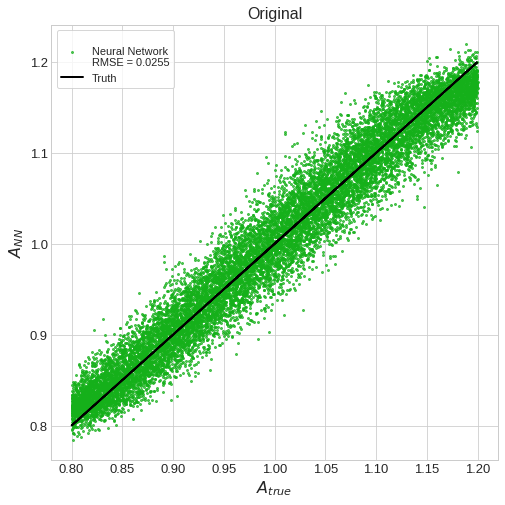

In [34]:
plt.style.use('seaborn-whitegrid')
from sklearn.metrics import mean_squared_error
test_loss = mean_squared_error(A_nn, A_true)

print(test_loss)


if analysis_mode == 'original':
    rho = 'Original'
    
elif analysis_mode == 'density':
    if case == 'max':
        rho = r'$\rho_{max} =$' + dens_cut_str
    
    elif case == 'min':
        rho = r'$\rho_{min} =$' + dens_cut_str

elif analysis_mode == 'top-hat-k':
    rho = r'$k_{max} =$' + kmax_cut_str

    
plt.figure(figsize = (8,8))
plt.scatter(A_true, A_nn, s = 4, color = 'xkcd:green', alpha = 0.7, label = '\nNeural Network\nRMSE = {:.4f}'.format(np.sqrt(test_loss)))
plt.plot(A_true, A_true, color = 'black', linewidth = 2, label = 'Truth')
plt.xlabel('$A_{true}$', fontsize = 16)
plt.ylabel('$A_{NN}$', fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(rho, fontsize = 16)
plt.legend(fontsize = 11, frameon=True)
#plt.text(1.05, 0.85, r"$MSE = 1.02 \times 10^{-3}$", fontsize = 14, bbox=dict(facecolor='white', edgecolor='lightgray'))
plt.show()

## Distribution of $A_{NN}$ for $A_{true}$ = $0.82, 1.0$ and $1.18$

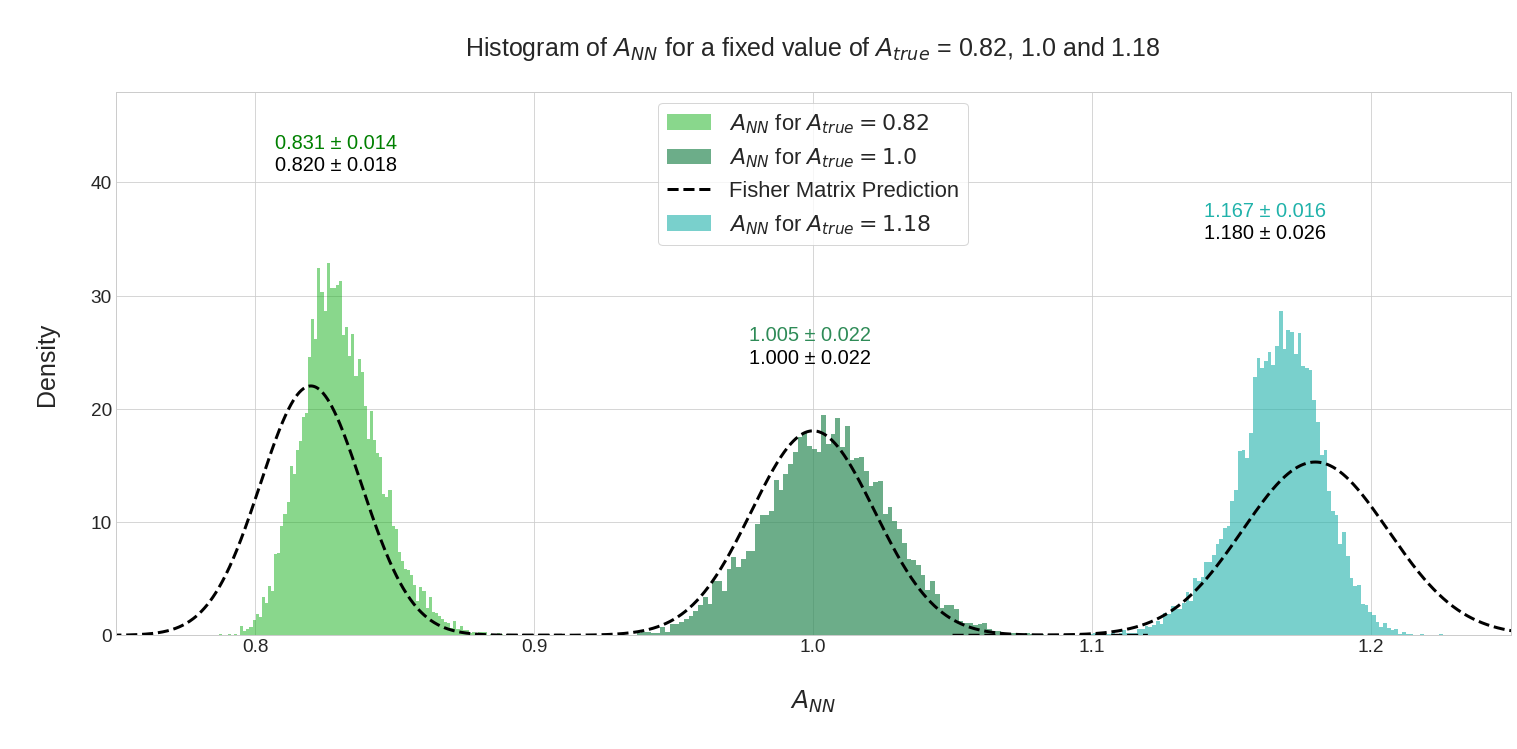

In [36]:
n = 10000
idx = np.random.permutation(n)

data_set_hist_100 = data_gen(n, 'all', dens_case, dens_cut_str, kmax_cut_str, 1.0)
data_set_hist_082 = data_gen(n, 'all', dens_case, dens_cut_str, kmax_cut_str, 0.82)
data_set_hist_118 = data_gen(n, 'all', dens_case, dens_cut_str, kmax_cut_str, 1.18)

sample_test_hist_100 = SubsetRandomSampler(idx)
#forming the test DataLoader and moving it to the device
test_dl_hist_100 = DataLoader(data_set_hist_100, batch_size = len(idx), sampler = sample_test_hist_100)

sample_test_hist_082 = SubsetRandomSampler(idx)
#forming the test DataLoader and moving it to the device
test_dl_hist_082 = DataLoader(data_set_hist_082, batch_size = len(idx), sampler = sample_test_hist_082)

sample_test_hist_118 = SubsetRandomSampler(idx)
#forming the test DataLoader and moving it to the device
test_dl_hist_118 = DataLoader(data_set_hist_118, batch_size = len(idx), sampler = sample_test_hist_118)

A_pred = np.zeros((3,n))
A_true = np.zeros((3,n))

mse_final = np.zeros(3)
rmse_final = np.zeros(3)

test_dl_hist_list = [test_dl_hist_082, test_dl_hist_100, test_dl_hist_118]

for j in range(3):
    for images, labels in test_dl_hist_list[j]:
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)

    for i in range(len(images)):
        A_pred[j][i] = out[i].item()*(1.2-0.8) + 0.8
        A_true[j][i] = labels[i].item()*(1.2-0.8) + 0.8


    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(A_pred[j], A_true[j])
    #print('Mean Squared Error (MSE) = ',mse)
    #print('Root Mean Squared Error (RMSE) = ', np.sqrt(mse))
    #print('\n')
    mse_final[j] = mse
    rmse_final[j] = np.sqrt(mse)

mu_theory = 0.82
std_theory = 0.82*np.sqrt(2)/64

from scipy.stats import norm

fig,ax = plt.subplots(figsize = (25,10))

plt.style.use('seaborn-whitegrid')

mu_th_1 = 0.82
std_th_1 = 0.82*np.sqrt(2)/64
#ax.hist(A_pred[0], bins = 100, density = True, color = 'green', histtype='step', linewidth=1)
ax.hist(A_pred[0], bins = 100, density = True, color = 'xkcd:green', alpha = 0.5, label = '$A_{NN}$ for $A_{true} = 0.82$')
xmin1, xmax1 = 0.7, 0.91
x1 = np.linspace(xmin1-0.04, xmax1, 1000)
p_fit_1 = norm.pdf(x1, mu_th_1, std_th_1)
ax.plot(x1, p_fit_1, color = 'black', linewidth=3, linestyle='dashed')
ax.text(0.807, 43, "{:.3f} ± {:.3f}".format(np.mean(A_pred[0]), np.std(A_pred[0])), fontsize = 20, color = 'green')
ax.text(0.807, 41, "{:.3f} ± {:.3f}".format(mu_th_1, std_th_1), fontsize = 20, color = 'black')


mu_th_2 = 1.0
std_th_2 = 1.0*np.sqrt(2)/64
#ax.hist(A_pred[1], bins = 100, density = True, color = 'green', histtype='step', linewidth=1, label = 'Neural Network Prediction')
ax.hist(A_pred[1], bins = 100, density = True, color = 'seagreen', alpha = 0.7, label = '$A_{NN}$ for $A_{true} = 1.0$')
xmin2, xmax2 = 0.89, 1.12
x2 = np.linspace(xmin2, xmax2, 1000)
p_fit_2 = norm.pdf(x2, mu_th_2, std_th_2)
ax.plot(x2, p_fit_2, color = 'black', linewidth=3, linestyle='dashed', label = 'Fisher Matrix Prediction')
ax.text(0.977, 26, "{:.3f} ± {:.3f}".format(np.mean(A_pred[1]), np.std(A_pred[1])), fontsize = 20, color = 'seagreen')
ax.text(0.977, 24, "{:.3f} ± {:.3f}".format(mu_th_2, std_th_2), fontsize = 20, color = 'black')


mu_th_3 = 1.18
std_th_3 = 1.18*np.sqrt(2)/64
#ax.hist(A_pred[2], bins = 100, density = True, color = 'green', histtype='step', linewidth=1)
ax.hist(A_pred[2], bins = 100, density = True, color = 'lightseagreen', alpha = 0.6, label = '$A_{NN}$ for $A_{true} = 1.18$')
xmin3, xmax3 = 1.05,1.3
x3 = np.linspace(xmin3, xmax3 + 0.04, 1000)
p_fit_3 = norm.pdf(x3, mu_th_3, std_th_3)
ax.plot(x3, p_fit_3, color = 'black', linewidth=3, linestyle='dashed')
ax.text(1.14, 37, "{:.3f} ± {:.3f}".format(np.mean(A_pred[2]), np.std(A_pred[2])), fontsize = 20, color = 'lightseagreen', label = 'Neural Network')
ax.text(1.14, 35, "{:.3f} ± {:.3f}".format(mu_th_3, std_th_3), fontsize = 20, color = 'black')

ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()

plt.ylim(0,48)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlim(0.75,1.25)
plt.xlabel('\n$A_{NN}$\n', fontsize = 25)
plt.ylabel('\nDensity\n', fontsize = 25)
plt.title('\nHistogram of $A_{NN}$ for a fixed value of $A_{true}$ = 0.82, 1.0 and 1.18\n', fontsize = 25)
plt.legend(loc = 9, fontsize = 22, frameon = True)
plt.show()
